In [192]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [193]:
def GenerateCounts(Xn,d):
    """
    Code to generate counts of each element from a sequence.
    """
    
    n = len(Xn)
    counts = np.zeros(d)
    for i in range(n):
        counts[Xn[i]-1] += 1
        
    return counts

def GenerateSymbolCount(Xn,symbol):
    """
    Code to generate count of a particular symbol
    """
    
    count=0
    for i in range(len(Xn)):
        if Xn[i]==symbol:
            count+=1
    return count

def GenerateZetas(Xn,d):
    """
    Code to generate the set of zetas from a sequence.
    """
    
    counts = GenerateCounts(Xn,d)
    zetas = []
    for j in range(d):
        if counts[j] not in zetas:
            zetas.append(counts[j])
            
    return zetas

In [194]:
def GenerateZetasNew(Xn,d):
    """
    Code to generate the set of zetas from a sequence.
    """
    
    counts = GenerateCounts(Xn,d)
    zetas = []
    for j in range(d):
        zetas.append(counts[j])
            
    return zetas

In [195]:
def acharya_distribution_sample(n):
    """
    Samples from the discrete distribution in Appendix B.11
    Args:
        n: number of samples in the iid sequence
    """
    # Calculate bucket parameters
    log_n = np.log10(n)
    #print(log_n)
    buckets = []
    total_mass = 0.0
    
    # Create probability buckets
    i_min = 1
    i_max = int(np.power(n,1/6))
    #print(i_min,i_max)
    
    for i in range(i_min, i_max + 1):
        # Base probability for this bucket
        base_p = (np.power(n,1/3)*log_n**3)/(1.5*n)+ i * ((np.power(n,1/6)*log_n**3)/(1.5*n))
        #print(base_p)
        # Number of symbols in this bucket
        num_symbols = int(np.sqrt(n)/log_n**3)
        #print(num_symbols)
        # Create two groups of symbols per bucket
        for _ in range(num_symbols):
            # First group: probability base_p
            buckets.append(base_p)
            
            # Second group: probability base_p + i/n
            total_mass += base_p

    # Normalize probabilities
    prob_array = np.array(buckets) / total_mass
    #print(prob_array)
    symbols = np.arange(1,len(prob_array)+1)
    d = len(prob_array)
    
    return np.random.choice(symbols, p=prob_array,size=n), d, prob_array

In [196]:
def GenerateUniformIID(n,d):
    """
    Generate a uniform sequence over the alphabet of size d.
    """
    
    return np.random.randint(low=1,high=d+1,size=n), np.ones((d))/d

def GenerateGeometricDuplicate(Xn_iid, Tmix):
    """
    Generate a random duplicated version of any iid-generated sequence.
    """
    
    Xn = []
    n0 = len(Xn_iid)
    tau = Tmix
    for i in range(n0):
        Dup = np.random.geometric(1/Tmix)
        tau = max(tau,Dup)
        Xn = Xn + [Xn_iid[i]]*Dup
        
    return Xn, tau

#The symbol duplication model is not mixing
def GenerateSymbolDuplicate(Xn_iid,Tmix,d):
    """
    Generate a random symbol-wise duplicated version of any iid-generated sequence.
    """
    Xn = []
    n0 = len(Xn_iid)
    duplication_factor = np.random.geometric(1/Tmix,size=d)
    tau =np.max(duplication_factor)
    #Symbol-wise duplication
    for i in range(n0):
        Xn = Xn+ [Xn_iid[i]]*duplication_factor[Xn_iid[i]-1]
    
    return Xn,tau

In [ ]:
#All the estimators are defined in this section
def GenerateStationaryMass(Xn,pi):
    """
    Generate the vector of count probabilities assigned by the stationary distribution
    """
    d = len(pi)                     #dimesion of the problem is the length of the stationary distribution
    n = len(Xn)                     #No of samples
    counts = GenerateCounts(Xn,d)
    #print(counts)
    Mstar = np.zeros((n+1))
    for i in range(d):
        Mstar[int(counts[i])] += pi[i]
    return Mstar

def EmpiricalEstimator(Xn,d,zeta_bar):
    """
    Compute the vector of count probabilities assigned by the plug-in estimator.
    """
    n = len(Xn)
    counts = GenerateCounts(Xn,d)
    #print(counts)
    Mhat = np.zeros((n+1))
    for i in range(n):
        zeta = int(counts[Xn[i]-1])
        if zeta > zeta_bar:
            Mhat[zeta] += 1/n

    return Mhat

def GTEstimator(Xn,zeta,d):
    """
    Estimate the mass on all elements occurring zeta times by the GT Estimator. This is for the iid sequence.
    """
    n = len(Xn)
    counts = GenerateCounts(Xn,d)
    Mhat = 0
    for j in range(d):
        if counts[j] == (zeta+1):
            Mhat += (zeta+1)
            
    Mhat /= n
    return Mhat


def WingIT(Xn, n, tmix,zeta):
    """
    Estimate the mass on all elements occurring zeta times by the WingIT Estimator.
    """
    Xloc = {}                           #Xloc stores the locations of the different symbols in Xn
    for i in range(n):
        if (Xn[i] not in Xloc):
            Xloc[Xn[i]] = []
        Xloc[Xn[i]].append(i)

    Mhat=0
    for i in range(0,n):
        locations = Xloc[Xn[i]]
        windowed_locs = [loc for loc in locations if not (i-tmix < loc < i+tmix)]

        if len(windowed_locs)==zeta:
            Mhat += 1

    Mhat /= n
        
    return min(Mhat,1)

def WingItLinear(Xn,tau,zeta_bar):
    """
    Compute the vector of count probabilities assigned by the WingIt estimator.
    """
    n = len(Xn)
    Xloc = {}                           #Xloc stores the locations of the different symbols in Xn
    for i in range(n):
        if (Xn[i] not in Xloc):
            Xloc[Xn[i]] = []
        Xloc[Xn[i]].append(i)

    Mhat = np.zeros((n+1))

    for i in range(n):
        count=0
        for j in range(max(0,i-tau),min(n,i+tau)):
            if Xn[i]==Xn[j]:
                count += 1
        zeta = len(Xloc[Xn[i]]) - count
    
        if zeta <= zeta_bar:
            Mhat[zeta] += 1/n
    
    return Mhat

In [ ]:
def GenerateTVError(n0,d,Tmix,M):
    """
    Code to generate total TV distance over empirical estimator.
    """
    
    TV_error = 0

    for k in range(M):
        Xn_iid,pi = GenerateUniformIID(n0,d)
        #Xn_iid,d,pi = acharya_distribution_sample(n=n0)
        Xn, tau = GenerateGeometricDuplicate(Xn_iid,Tmix)   #tau is the window size for the wing-it estimator
        n = len(Xn)
        zeta_bar = int(np.power(n,1/3))
        Mhat_wingit = WingItLinear(Xn,tau,zeta_bar)         #Stores the vector of count probabilities for the wing-it estimator
        Mhat_PI = EmpiricalEstimator(Xn,d,zeta_bar)         #Stores the vector of count probabilities for the plug-in estimator
        Mstar = GenerateStationaryMass(Xn,pi)               #Stores the actual vector of count probabilities 

        TV_error += np.sum(np.abs(Mhat_wingit+Mhat_PI-Mstar))
    TV_error /= M                                               #Average over M instances
    return TV_error

In [199]:
#This section of the code plots the TV errors
powers = np.linspace(6,10,10)

n0_list=[]
for power in powers:
    n0_list.append(int(np.exp(power)))

# n0_list = [int(np.exp(10))]

#Set the mixing time parameter tau = n0^c
c=0.1

TV_errors = []

for n0 in tqdm(n0_list):
    d = (int)(np.power(n0,1))
    M = 100
    Tmix = int(np.round(np.power(n0,c)))
    errors = GenerateTVError(n0,d,Tmix,M) 
    TV_errors.append(errors)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [08:17<00:00, 49.79s/it] 


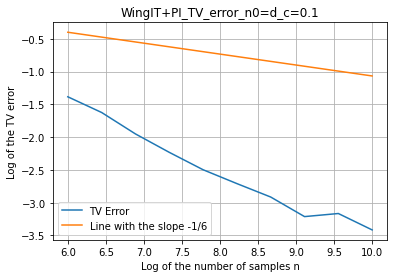

In [200]:
plt.plot(np.log(n0_list),np.log(TV_errors),label="TV Error")
plt.plot(np.log(n0_list),(-1/6)*np.log(n0_list)+0.6,label="Line with the slope -1/6")
plt.title(f"WingIT+PI_TV_error_n0=d_c={c}")
plt.ylabel("Log of the TV error")
plt.xlabel("Log of the number of samples n")
plt.legend()
plt.grid()
plt.savefig(f"WingIT+PI_TV_error_n0=d_c={c}.pdf")
np.save(f"WingIT+PI_TV_error_n0=d_c={c}",TV_errors)

In [204]:
# #This section plots the histogram of the frequencies
# n0=int(np.exp(10))
# d = int(np.power(n0,1))
# Tmix = 5#int(np.power(n0,0.5))
# Xn_iid,pi = GenerateUniformIID(n0,d)
# #Xn_iid,d,pi = acharya_distribution_sample(n0)
# Xn = GenerateGeometricDuplicate(Xn_iid,Tmix)
# Xn_symbol = GenerateSymbolDuplicate(Xn_iid,Tmix,d)
# zetas_iid = GenerateZetasNew(Xn_iid,d)
# zetas = GenerateZetasNew(Xn,d)
# zetas_symbol = GenerateZetasNew(Xn_symbol,d)


In [205]:
# # Create vertically stacked subplots
# fig, axs = plt.subplots(3, figsize=(8, 10), constrained_layout=True)
# fig.suptitle('Histograms', fontsize=16)

# # Histogram 1
# axs[0].hist(zetas_iid, bins=30, color='steelblue', edgecolor='black')
# axs[0].set_title('Histogram of IID sequence')
# axs[0].set_xlabel('Zetas')
# axs[0].set_ylabel('No of Zetas')
# axs[0].grid(True)

# # Histogram 2
# axs[1].hist(zetas, bins=30, color='coral', edgecolor='black')
# axs[1].set_title('Histogram of Sample Duplication')
# axs[1].set_xlabel('Zetas')
# axs[1].set_ylabel('No of Zetas')
# axs[1].grid(True)

# # Histogram 3
# axs[2].hist(zetas_symbol, bins=30, color='mediumseagreen', edgecolor='black')
# axs[2].set_title('Histogram of Symbol Duplications')
# axs[2].set_xlabel('Zetas')
# axs[2].set_ylabel('No of Zetas')
# axs[2].grid(True)

# plt.savefig("Histogram.pdf")

# # Display the plot
# plt.show()
